In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import sys
from torch.utils.data.dataset import random_split
from torchsummary import summary

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
trainset_path = "archive\\OCT2017_\\train"
testset_path = "archive\\OCT2017_\\test"

batch_size = 32
image_size = 64

train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.Grayscale(),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(30),
    transforms.ToTensor(),
])

train_val_dataset = datasets.ImageFolder(trainset_path, transform=train_transforms)
train_dataset, valid_dataset = random_split(train_val_dataset, [len(train_val_dataset)-1000, 1000])
test_dataset = datasets.ImageFolder(testset_path, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

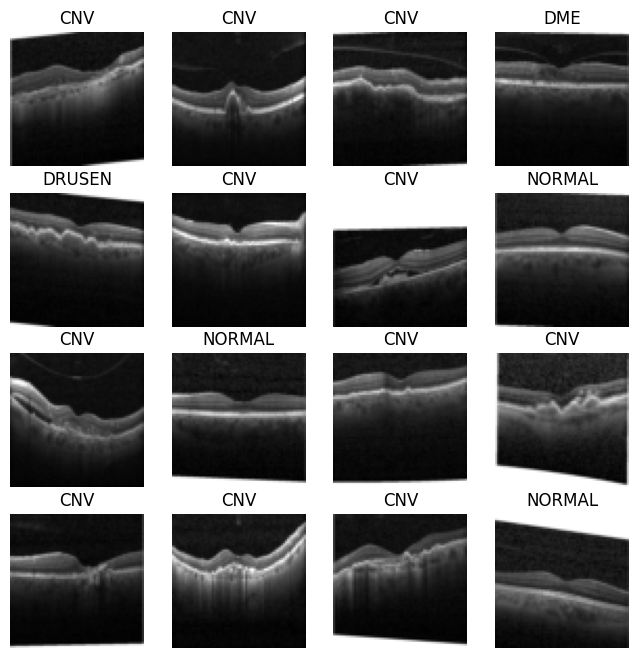

In [4]:
class_labels=["CNV","DME","DRUSEN","NORMAL"]
figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(class_labels[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [5]:
kernel = torch.tensor([[1, 0, -1], [0, 0, 0], [-1, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, bias=False)
conv.weight = nn.Parameter(kernel, requires_grad=False)

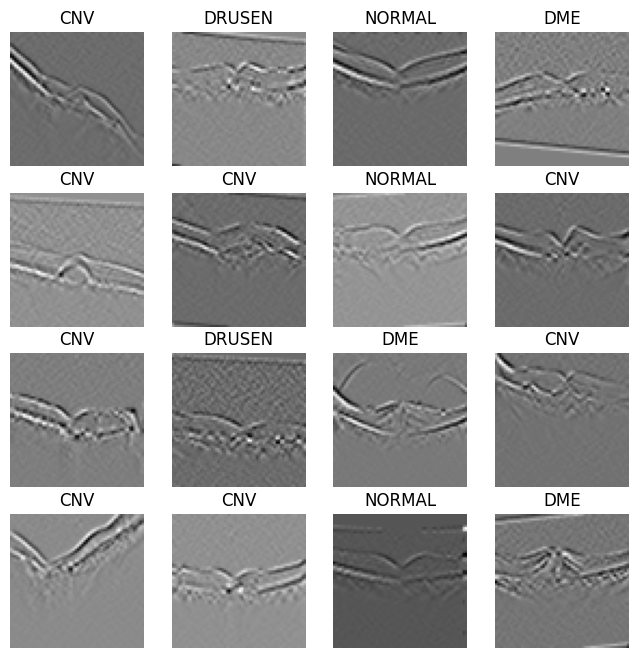

In [6]:
class_labels=["CNV","DME","DRUSEN","NORMAL"]
figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(class_labels[label])
    plt.axis("off")
    img = conv(img)
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [34]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Two convolutional layers and one batchnormalization layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, stride = 1, padding = 1)
        self.BN1 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
        self.BN2 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.99, affine=True, track_running_stats=True)
        
        self.dropout = nn.Dropout2d(p=0.1)
        self.avg_pool = nn.AdaptiveAvgPool2d((4, 4))
        # Two fully connected layers
        self.fc1 = nn.Linear(64*4*4, 128) # 64*64*64 = 262144
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):

        # Pass input through first convolutional layer
        x = self.conv1(x)
        x = self.BN1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Pass output of first conv layer through second convolutional layer
        x = self.conv2(x)
        x = self.BN2(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Flatten output of second conv layer
        x = self.avg_pool(x)
        x = x.view(-1,64*4*4)
        # Pass flattened output through first Linear layer
        x = self.fc1(x)
        x = F.relu(x)

        # Pass output of first Linear layer to second linear layer
        x = self.fc2(x)
        return x

In [35]:
model = CNN().to(device)
summary(model, (1,image_size, image_size))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
       BatchNorm2d-2           [-1, 32, 64, 64]              64
         Dropout2d-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
       BatchNorm2d-5           [-1, 64, 64, 64]             128
         Dropout2d-6           [-1, 64, 64, 64]               0
 AdaptiveAvgPool2d-7             [-1, 64, 4, 4]               0
            Linear-8                  [-1, 128]         131,200
            Linear-9                    [-1, 4]             516
Total params: 150,724
Trainable params: 150,724
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 9.01
Params size (MB): 0.57
Estimated Total Size (MB): 9.60
-------------------------------------------

In [37]:
def train(model, train_loader, valid_loader, epochs = 10, lr = 0.001):
    # Use Adam optimizer to update model weights
    optimizer = optim.Adam(model.parameters(), lr = lr)
    # Use cross-entropy loss function
    criterion = nn.CrossEntropyLoss()
    # Performance curves data
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    
    for epoch in range(epochs):
        # Set model to training mode
        model.train()
        # Initialize epoch loss and accuracy
        epoch_loss = 0.0
        correct = 0
        total = 0
        # Iterate over training data
        for batch_number, (inputs, labels) in enumerate(train_loader):
            # Get from dataloader and send to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Zero out gradients
            optimizer.zero_grad()
            # Compute model output and loss
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            # Backpropagate loss and update model weights
            loss.backward()
            optimizer.step()
            # Accumulate loss and correct predictions for epoch
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            sys.stdout.flush()
            if batch_number%100==0:
                print(f'Epoch {epoch+1}/{epochs}, Batch number: {batch_number}, Cumulated accuracy: {correct/total}')
        # Calculate epoch loss and accuracy
        epoch_loss /= len(train_loader)
        epoch_acc = correct/total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Train loss: {epoch_loss:.4f}, Train accuracy: {epoch_acc:.4f}')
        
        # Set model to evaluation mode
        model.eval()
        # Initialize epoch loss and accuracy
        epoch_loss = 0.0
        correct = 0
        total = 0
        # Iterate over test data
        for inputs, labels in valid_loader:
            # Get from dataloader and send to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Compute model output and loss
            # (No grad computation here, as it is the test data)
            with torch.no_grad():
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
            # Accumulate loss and correct predictions for epoch
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # Calculate epoch loss and accuracy
        epoch_loss /= len(valid_loader)
        epoch_acc = correct/total
        valid_losses.append(epoch_loss)
        valid_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Valid loss: {epoch_loss:.4f}, Valid accuracy: {epoch_acc:.4f}')
        torch.save(model.state_dict(),f'cnn_epoch{epoch}.pt')
    
    return train_losses, train_accuracies, valid_losses, valid_accuracies

In [38]:
model = CNN().to(device)
train_losses, train_accuracies, valid_losses, valid_accuracies = train(model, \
                                                                     train_loader, \
                                                                     valid_loader, \
                                                                     epochs = 30, \
                                                                     lr = 0.001)

Epoch 1/30, Batch number: 0, Cumulated accuracy: 0.40625
Epoch 1/30, Batch number: 100, Cumulated accuracy: 0.49845297029702973
Epoch 1/30, Batch number: 200, Cumulated accuracy: 0.5763370646766169
Epoch 1/30, Batch number: 300, Cumulated accuracy: 0.6064161129568106
Epoch 1/30, Batch number: 400, Cumulated accuracy: 0.6224283042394015
Epoch 1/30, Batch number: 500, Cumulated accuracy: 0.6375374251497006
Epoch 1/30, Batch number: 600, Cumulated accuracy: 0.6480345257903494
Epoch 1/30, Batch number: 700, Cumulated accuracy: 0.6554921540656206
Epoch 1/30, Batch number: 800, Cumulated accuracy: 0.6605024968789014
Epoch 1/30, Batch number: 900, Cumulated accuracy: 0.6667591564927858
Epoch 1/30, Batch number: 1000, Cumulated accuracy: 0.6709852647352648
Epoch 1/30, Batch number: 1100, Cumulated accuracy: 0.6763169845594914
Epoch 1/30, Batch number: 1200, Cumulated accuracy: 0.6811251040799334
Epoch 1/30, Batch number: 1300, Cumulated accuracy: 0.6851940814757879
Epoch 1/30, Batch number: 14

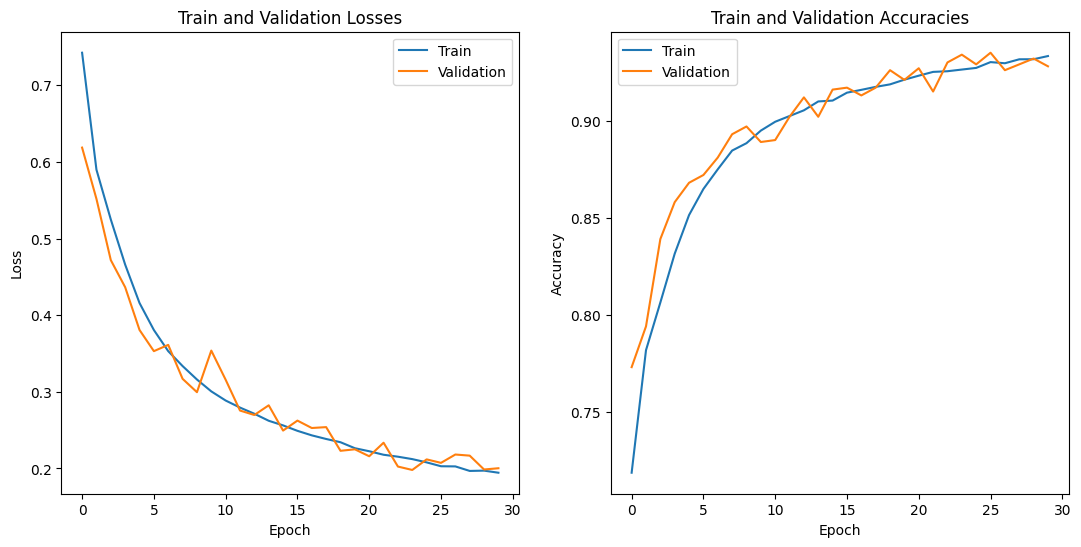

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

ax1.plot(train_losses, label='Train')
ax1.plot(valid_losses, label='Validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Train and Validation Losses')
ax1.legend()

ax2.plot(train_accuracies, label='Train')
ax2.plot(valid_accuracies, label='Validation')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Train and Validation Accuracies')
ax2.legend()

plt.show()

In [42]:
torch.save(model.state_dict(),f'cnn.pt')

In [43]:
def test(model, test_loader):
    model.eval()
    epoch_loss = 0.0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
        epoch_loss += loss.item()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss /= len(valid_loader)
    epoch_acc = correct/total
    print(f'--- test loss: {epoch_loss:.4f}, test accuracy: {epoch_acc:.4f}')


In [45]:
#change the virable into the best performance model
best_model = 'cnn_epoch28.pt'

In [46]:
model.load_state_dict(torch.load(best_model))

<All keys matched successfully>

In [47]:
test(model, test_loader)

--- test loss: 0.0629, test accuracy: 0.9855


In [48]:
from sklearn.metrics import confusion_matrix
import numpy as np

In [49]:
def get_pred(model, test_loader):
    model.eval()
    y_pred_list = []
    y_true_list = []
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
        y_pred_list.append(predicted.cpu())
        y_true_list.append(labels.cpu())
        y_pred = torch.cat(y_pred_list, dim=0)
        y_true = torch.cat(y_true_list, dim=0)
    return y_true, y_pred

In [50]:
y_true, y_pred = get_pred(model, test_loader)
cm = confusion_matrix(y_true.numpy(), y_pred.numpy())

In [51]:
y2_true, y2_pred = get_pred(model, train_loader)
cm2 = confusion_matrix(y2_true.numpy(), y2_pred.numpy())

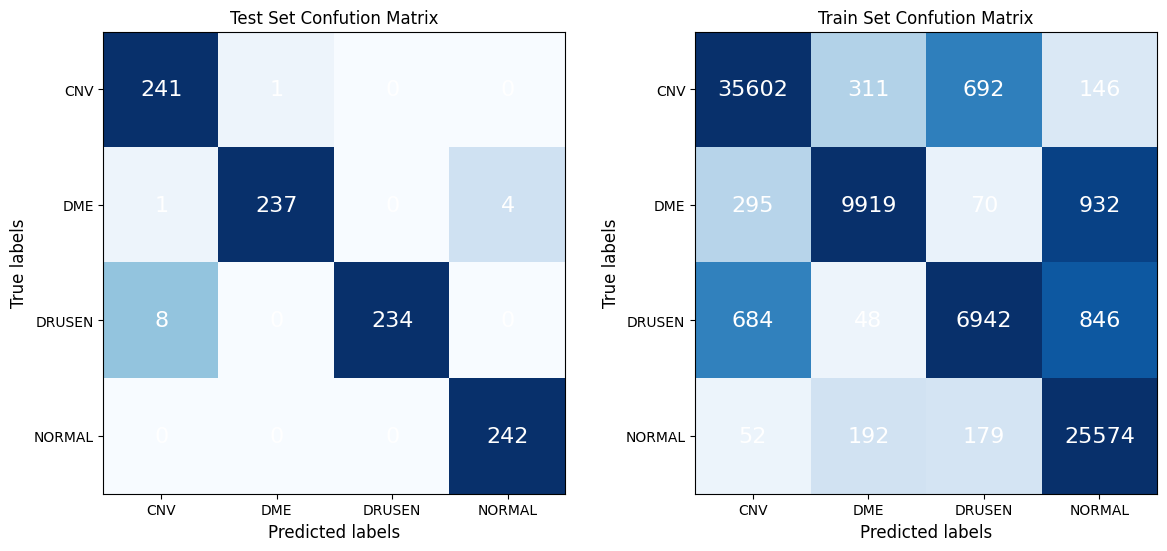

In [52]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14, 6))
ax1.imshow(cm, cmap='Blues', vmin=0, vmax=20)
ax1.grid(False)
ax1.set_xlabel('Predicted labels', fontsize=12, color='black')
ax1.set_ylabel('True labels', fontsize=12, color='black')
ax1.set_xticks(np.arange(4))
ax1.set_yticks(np.arange(4))
ax1.set_xticklabels(["CNV","DME","DRUSEN","NORMAL"], fontsize=10, color='black')
ax1.set_yticklabels(["CNV","DME","DRUSEN","NORMAL"], fontsize=10, color='black')

for i in range(4):
    for j in range(4):
        ax1.text(j, i, cm[i, j], ha='center', va='center', color='white', fontsize=16)

ax2.imshow(cm2, cmap='Blues', vmin=0, vmax=1000)
ax2.grid(False)
ax2.set_xlabel('Predicted labels', fontsize=12, color='black')
ax2.set_ylabel('True labels', fontsize=12, color='black')
ax2.set_xticks(np.arange(4))
ax2.set_yticks(np.arange(4))
ax2.set_xticklabels(["CNV","DME","DRUSEN","NORMAL"], fontsize=10, color='black')
ax2.set_yticklabels(["CNV","DME","DRUSEN","NORMAL"], fontsize=10, color='black')

for i in range(4):
    for j in range(4):
        ax2.text(j, i, cm2[i, j], ha='center', va='center', color='white', fontsize=16)

ax1.set_title("Test Set Confution Matrix")
ax2.set_title("Train Set Confution Matrix")


plt.show()